In [1]:
import pandas as pd
from tqdm import tqdm
from datetime import datetime, timedelta
import numpy as np
import holidays

nl_holidays = holidays.NL()
from datetime import datetime, timedelta

import matplotlib.pyplot as plt

import sys
sys.path.append("../")
import asset.MyPlot as mp
import asset.DataSupply as ds

import warnings
warnings.filterwarnings("ignore")

## Get specifications of sewage from old data(until 2019-08-31)
## Training model on new data(from 2019-09-01)

#### Get the minimum level(m) and volume(m3) per meter level for Bokhoven, Haarsteeg, Oude engelenseweg

In [2]:
# for save time, the code in this cell is exactly same as the result from the cell blw

specification = {
    "bokhoven": {"min_level": -0.6, "m3_per_m": 4.348602514328682},
    "haarsteeg": {"min_level": -4.1, "m3_per_m": 87.85909502482393},
    "oude_engelenseweg": {"min_level": 0.0, "m3_per_m": 3.5645260088514346},
}

In [3]:
# # your attention, time consuming

# specification = ds.GetSpecification(["bokhoven","haarsteeg","oude_engelenseweg"])

In [4]:
pumps = {
    "bokhoven": {"maxSpeed": 20, "capacity": 49},
    "haarsteeg": {"maxSpeed": 3600, "capacity": 2350},
    "oude_engelenseweg": {"maxSpeed": 4000, "capacity": 1000},
}

In [5]:
df_rain_historical, dct_areas = ds.GetRainfallByPumps(
    ["bokhoven", "haarsteeg", "oude_engelenseweg"]
)

100%|██████████| 22/22 [00:10<00:00,  2.04it/s]


#### Generate Data for training model

In [8]:
# for save time, the code in this cell is exactly same as the result from the cell blw

data_bokhoven = pd.read_csv("../asset/data/model_data_bokhoven.csv", index_col=0, parse_dates=True)
data_haarsteeg = pd.read_csv(
    "../asset/data/model_data_haarsteeg.csv", index_col=0, parse_dates=True
)
data_oude_engelenseweg = pd.read_csv(
    "../asset/data/model_data_oude_engelenseweg.csv", index_col=0, parse_dates=True
)

In [6]:
## your attention, time consuming

# data_bokhoven = ds.GenerateMLdata(
#     "bokhoven",
#     specification["bokhoven"]["m3_per_m"],
#     specification["bokhoven"]["min_level"],
#     df_rain_historical,
#     dct_areas,
# )

# data_haarsteeg = ds.GenerateMLdata(
#     "haarsteeg",
#     specification["haarsteeg"]["m3_per_m"],
#     specification["haarsteeg"]["min_level"],
#     df_rain_historical,
#     dct_areas,
# )

# data_oude_engelenseweg = ds.GenerateMLdata(
#     "oude_engelenseweg",
#     specification["oude_engelenseweg"]["m3_per_m"],
#     specification["oude_engelenseweg"]["min_level"],
#     df_rain_historical,
#     dct_areas,
# )

100%|██████████| 1/1 [00:00<00:00, 26.63it/s]
482395it [00:30, 15976.17it/s]
482395it [00:51, 9309.63it/s] 
3169it [00:00, 11741.96it/s]


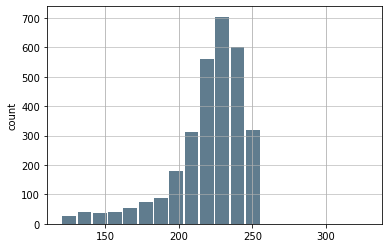

In [10]:
mp.ValueDistributionPlot(data_oude_engelenseweg["oude_engelenseweg_level_value"])

In [11]:
data = data_oude_engelenseweg.join(data_haarsteeg, how="inner").join(
    data_bokhoven, how="inner"
)

In [12]:
data = data[1:]
data["total_flow_value"] = (
    data["oude_engelenseweg_flow_value"]
    + data["bokhoven_flow_value"]
    + data["haarsteeg_flow_value"]
)

In [13]:
data["hour"] = data.index.hour
data["day"] = data.index.day
data["weekday"] = data.index.weekday
data["month"] = data.index.month
data["is_holiday"] = [int(i.date() in nl_holidays) for i in data.index]


data.head(3)

,oude_engelenseweg_in_flow_vol,oude_engelenseweg_flow_value,oude_engelenseweg_level_value,oude_engelenseweg_last_in_flow_vol,oude_engelenseweg_vol_remain,haarsteeg_in_flow_vol,haarsteeg_flow_value,haarsteeg_level_value,haarsteeg_last_in_flow_vol,haarsteeg_vol_remain,...,bokhoven_flow_value,bokhoven_level_value,bokhoven_last_in_flow_vol,bokhoven_vol_remain,total_flow_value,hour,day,weekday,month,is_holiday
end_hour,,,,,,,,,,,,,,,,,,,,,
2019-09-01 20:00:00,673.460157,681.009167,221.067,426.794957,787.999071,216.133374,233.197500,-1.90,359.490130,193.290009,...,3.0,-0.120000,1.493020,2.087329,917.206667,20,1,6,9,0
2019-09-01 21:00:00,409.207586,492.535833,246.933,673.460157,880.199101,556.148072,476.507167,-1.97,216.133374,187.139872,...,0.0,0.423333,1.466006,4.450070,969.043000,21,1,6,9,0
2019-09-03 04:00:00,198.665293,175.769667,231.067,409.207586,823.644331,498.600364,343.505333,-2.42,556.148072,147.603280,...,0.0,-0.105714,0.556438,2.149452,519.275000,4,3,1,9,0


In [14]:
# estimators
from sklearn.ensemble import RandomForestRegressor

# evaluators
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error


In [15]:
names = ["bokhoven", "haarsteeg", "oude_engelenseweg"]

dct_models = {}

for n in names:
    X_cols = [
        f"{n}_last_in_flow_vol",
        "hour",
        "day",
        "weekday",
        "month",
        "is_holiday",
    ]
    y_col = f"{n}_in_flow_vol"

    X = data[X_cols]
    y = data[y_col]

    rf = RandomForestRegressor(
        bootstrap=True,
        random_state=666,
        max_features="auto",
        n_estimators=50,
        max_depth=10,
        min_samples_split=30,
        min_samples_leaf=1,
    )
    rf.fit(X, y)
    y_predicted = rf.predict(X)

    dct_models[n] = {
        "X_cols": X_cols,
        "y_col": y_col,
        "y_predicted": y_predicted,
        "model": rf,
    }

In [16]:
for n in dct_models:
    col_name = dct_models[n]["y_col"]
    data[f"{col_name}_predicted"] = dct_models[n]["y_predicted"]

In [17]:
mean_flow = np.mean(data["total_flow_value"])

$flow_{mean}$ :$~~~~~~~$ expected total flow from pumps from average of hostorical\
$Cap_i$: $~~~~~~~~~~~~~~$ capacity of water($m^3$) in sewage system of $i$\
$S_{i(t)}$: $~~~~~~~~~~~~~~~~$water($m^3$) remaining in sewage system of $i$ on end of the current hour $t$\
$Vin_i(t+1)$: $~~~~~$water($m^3$) in-flow in sewage system of $i$ in next hour, (predicted)\
$x_i$: $~~~~~~~~~~~~~~~~~~~~$binary if switch-on pump $i$\
$i \in \{all~pump~stations\}$

$Min~~~~~|flow_{mean} - \sum_i[x_i \cdot (S_{i(t)}+Vin_{i(t+1)})]|$ \
$s.t~~~~~~~~S_{i(t+1)}+Vin_{i(t+2)} < Cap_i$\
$~~~~~~~~~~~~~x_i \in {0,1}$


In [18]:
class Pump:
    def __init__(
        self, name, date, maxSpeed, capacity, remainVol, lastInflowVol, X_cols, model
    ):
        self.name = name
        self.date = date
        self.maxSpeed = maxSpeed
        self.capacity = capacity
        self.remainVol = remainVol
        self.lastInflowVol = lastInflowVol
        self.X_cols = X_cols
        self.model = model
        self.nextInflowVol = self.GetNextInflowVol()

    def OneHourAfter(self):
        self.date += timedelta(hours=1)
        self.remainVol += self.nextInflowVol
        self.nextInflowVol = self.GetNextInflowVol()

    def GetNextInflowVol(self):
        newDate = self.date + timedelta(hours=1)
        dct = {f"{self.name}_last_in_flow_vol": self.lastInflowVol}
        dct["hour"] = newDate.hour
        dct["day"] = newDate.day
        dct["weekday"] = newDate.weekday()
        dct["month"] = newDate.month
        dct["is_holiday"] = int(newDate.date() in nl_holidays)
        df = pd.DataFrame.from_dict(dct, orient="index").T
        return self.model.predict(df[self.X_cols])[0]

    def WillOverflow(self):
        return (self.remainVol + self.nextInflowVol > self.capacity)or (self.remainVol + self.nextInflowVol>1000)

    def RunPump(self, toRun):
        if not toRun:
            return 0
        out_flow = 0
        if self.maxSpeed > self.remainVol:
            out_flow = self.remainVol
            self.remainVol = 0
        else:
            out_flow = self.maxSpeed
            self.remainVol -= self.maxSpeed
        return out_flow


class PumpingSystem:
    def __init__(self, mean_flow, dct_pumps, idx, row):
        self.mean_flow = mean_flow
        self.pumps = dict()
        self.date = idx
        for p in dct_pumps:
            self.pumps[p] = Pump(
                p,
                idx,
                dct_pumps[p]["maxSpeed"],
                dct_pumps[p]["capacity"],
                row[f"{p}_vol_remain"],
                row[f"{n}_in_flow_vol"],
                dct_models[p]["X_cols"],
                dct_models[p]["model"],
            )

    def OperatingPump(self):
        self.date += timedelta(hours=1)
        output = {"time": self.date}
        decision = dict()
        for p in self.pumps:
            self.pumps[p].OneHourAfter()
        lst_pumps = [self.pumps[p] for p in self.pumps]
        lst_candidate_idx = self.GetCandidates(lst_pumps)
        theBest = self.GetBestSelection(lst_pumps, lst_candidate_idx)
        for i in range(len(lst_pumps)):
            toRun = False
            if i in theBest:
                toRun = True
            output[lst_pumps[i].name] = lst_pumps[i].RunPump(toRun)
        return output

    def GetBestSelection(self, lst_pumps, lst_candidate_idx):

        best = None
        abs_diff = float("inf")
        for cs in lst_candidate_idx:
            add = 0
            for i in cs:
                add += lst_pumps[i].remainVol
            if abs(add - self.mean_flow) < abs_diff:
                abs_diff = abs(add - self.mean_flow)
                best = cs
        return best

    def GetCandidates(self, lst_pumps):
        comb = []
        for i in range(3):
            for j in range(i, 3):
                comb.append(list(set([i, j])))
        comb.append(list(range(0, 3)))
        candidate = []
        for i in range(len(lst_pumps)):
            if lst_pumps[i].WillOverflow():  # shall not overflow
                candidate.append(i)
        if len(candidate) > 0:
            output = []
            for c in comb:
                if all(item in c for item in candidate):
                    output.append(c)
            return output
        return comb




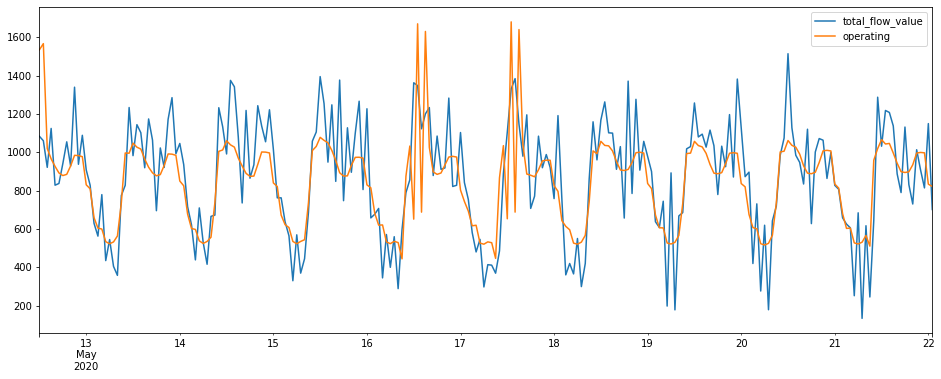

In [19]:
start = pd.to_datetime("2020-05-12 11:00:00")
end = pd.to_datetime("2020-05-22 12:00:00")

sub_data = data[start:end][["total_flow_value"]]

row = data.loc[
    start,
]
ps = PumpingSystem(mean_flow, pumps, start, row)

prediction = []
while start < end:
    prediction.append(ps.OperatingPump())
    start += timedelta(hours=1)


df_pre = pd.DataFrame(prediction)
df_pre.set_index("time", inplace=True)
df_pre["operating"] = (
    df_pre["bokhoven"] + df_pre["haarsteeg"] + df_pre["oude_engelenseweg"]
)
df_pre = df_pre.join(sub_data, how="inner")
df_pre[["total_flow_value", "operating"]].plot(figsize=(16, 6))

In [21]:
np.std(df_pre["operating"]), np.std(df_pre["total_flow_value"])

(222.41961122791378, 294.52471430791843)

In [22]:
np.sum(df_pre["operating"]), np.sum(df_pre["total_flow_value"])

(194745.74673474766, 200611.675)

In [23]:
df_pre[df_pre["haarsteeg"] == 0].index.to_list()

[Timestamp('2020-05-12 12:00:00'),
 Timestamp('2020-05-16 12:00:00'),
 Timestamp('2020-05-16 14:00:00'),
 Timestamp('2020-05-17 12:00:00'),
 Timestamp('2020-05-17 14:00:00')]